# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,2.467622,True,10.282363
1,0.767867,False,0.863509
2,0.347118,False,1.821114
3,-0.305876,False,-1.020255
4,0.123471,False,-0.873366
...,...,...,...
995,-0.093079,True,5.190158
996,-2.491506,True,0.373064
997,0.014719,True,4.284487
998,0.184560,True,5.416853


<AxesSubplot:xlabel='v0'>

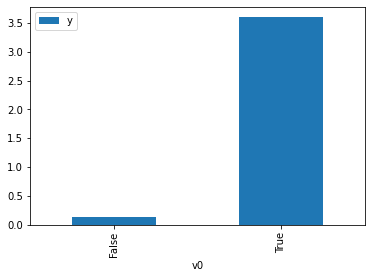

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

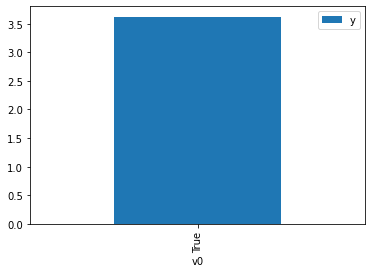

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.241934,False,-0.738336,0.639736,1.563146
1,-1.556452,False,-4.746635,0.981869,1.018466
2,-0.226442,False,-0.750365,0.630401,1.586291
3,0.289549,False,0.468551,0.308405,3.242491
4,0.387474,False,-0.240465,0.256893,3.892675
...,...,...,...,...,...
995,0.449399,False,1.805694,0.227377,4.397983
996,-0.512677,False,-1.156469,0.782130,1.278559
997,-1.151929,False,-2.374304,0.949794,1.052860
998,-1.027078,False,-1.601122,0.931853,1.073130


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.757775,True,6.813301,0.883390,1.132003
1,2.611090,True,8.626946,0.998935,1.001067
2,0.305056,True,5.314902,0.700127,1.428312
3,-0.791335,True,3.847875,0.118930,8.408331
4,0.001986,True,6.103948,0.514984,1.941810
...,...,...,...,...,...
995,-2.491506,True,0.373064,0.001621,616.777747
996,0.757775,True,6.813301,0.883390,1.132003
997,0.306244,True,5.625061,0.700776,1.426991
998,0.181313,True,5.617617,0.628592,1.590856


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.967
Model:                            OLS   Adj. R-squared (uncentered):              0.967
Method:                 Least Squares   F-statistic:                          1.454e+04
Date:                Tue, 19 Jul 2022   Prob (F-statistic):                        0.00
Time:                        20:29:23   Log-Likelihood:                         -1419.4
No. Observations:                1000   AIC:                                      2843.
Df Residuals:                     998   BIC:                                      2853.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.8668      0.037     50.151      0.000       1.794       1.940
x2             5.0069      0.052     95.965      0.000       4.905       5.109
==============================================================================
Omnibus:                        1.262   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.532   Jarque-Bera (JB):                1.164
Skew:                           0.008   Prob(JB):                        0.559
Kurtosis:                       3.166   Cond. No.                         2.27
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""